In [246]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pywt

filepath = r"D:\Downloads\새 폴더 (3)\yahoo_1.csv"

In [247]:
yahoo = pd.read_csv(filepath)

In [248]:
train_size = int(0.7 * len(yahoo))
train_data_raw = yahoo[:train_size].values
test_data_raw = yahoo[train_size:].values

In [249]:
segment_sizes = [15,30,60,120,200]
cluster_sizes = [3,4,5,7]

import warnings
warnings.filterwarnings("ignore")

def prepare_feature(train_data, test_data, segment_length):
    # Extract training features
    train_segments = []
    for i in range(0, len(train_data) - segment_length + 1, 1):  
        segment = train_data[i:i + segment_length]
        difference = [abs(train_data[j]-train_data[j-1]) for j in range(i+1, i+segment_length)]# 계차의 절댓값
        features = [
            np.mean(segment),
            np.std(segment),
            np.max(segment),
            np.mean(difference),
            np.std(difference),
            np.max(difference)
        ]

        # 이산 웨이블릿 변환
        coeffs = pywt.wavedec(segment, 'haar', level=1)
        for c in coeffs:
            features.append(np.mean(c))
            features.append(np.std(c))
            features.append(np.max(c))
            features.append(np.sum(np.square(c)))

        train_segments.append(features)

    test_segments = []
    for i in range(0, len(test_data) - segment_length + 1, 1):  
        segment = test_data[i:i + segment_length]
        difference = [abs(test_data[j]-test_data[j-1]) for j in range(i+1, i+segment_length)]
        features = [
            np.mean(segment),
            np.std(segment),
            np.max(segment),
            np.mean(difference),
            np.std(difference),
            np.max(difference)
        ]

        # 이산 웨이블릿 변환
        coeffs = pywt.wavedec(segment, 'haar', level=1)
        for c in coeffs:
            features.append(np.mean(c))
            features.append(np.std(c))
            features.append(np.max(c))
            features.append(np.sum(np.square(c)))
        
        test_segments.append(features)

    train_features = np.array(train_segments)
    test_features = np.array(test_segments)
    # print(train_features)
    # print(test_features)
    return train_features, test_features

def scale(train, test):
    scaler = MinMaxScaler()
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    test_data = scaler.transform(test)
    return train_data,test_data

# Try different number of clusters (hyperparameter tuning)
def cluster(train_features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    train_labels = kmeans.fit_predict(train_features)


    return train_labels

def plot(train_features, train_labels, test_features, segment_length, n_clusters, _, __):

    if len(np.unique(train_labels)) > 1:
        sil_score = silhouette_score(train_features, train_labels)
        print(f"len: {segment_length}, Clusters: {n_clusters}, Silhouette: {sil_score:.3f}")

    pca = PCA(n_components=2)
    reduced = pca.fit_transform(train_features)

    #plot
    plt.scatter(reduced[:,0], reduced[:,1], c=train_labels, s=10)
    plt.title(f"Clustering ({segment_length})({n_clusters})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")

    plt.figure(figsize=(18,5))
    plt.show()

In [250]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def plot(train_features, train_labels, test_features, segment_length, n_clusters,
         train_data_raw, test_data_raw):
    if len(np.unique(train_labels)) > 1:
        sil_score = silhouette_score(train_features, train_labels)
    #     print(f"len: {segment_length}, Clusters: {n_clusters}, Silhouette: {sil_score:.3f}")

    # PCA on train features
    pca = PCA(n_components=2)
    reduced_train = pca.fit_transform(train_features)

    # Cluster centers in original feature space
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(train_features)
    centers = kmeans.cluster_centers_
    centers_pca = pca.transform(centers)

    # Predict test clusters with kmeans
    test_predictions = kmeans.predict(test_features)


    # Calculate confidence scores: test_features와 클러스터 중심까지 거리 -> 거리 작을수록 신뢰 높음
    distances = kmeans.transform(test_features)  # shape=(test_samples, n_clusters)
    min_distances = np.min(distances, axis=1)
    confidence_scores = 1 / (1 + min_distances)  # 값이 클수록 confident

    # Dummy confidence scores for example (replace with your real confidence calculation)
    # confidence_scores = np.random.rand(len(test_predictions))

    plt.figure(figsize=(9, 6))

    # Plot 1: Training data raw with cluster color spans
    plt.subplot(2, 3, 1)
    segment_starts_train = range(0, len(train_data_raw) - segment_length + 1, 1)
    
    colors_train = plt.cm.tab10(train_labels % 10)  # modulo to avoid index error if >10 clusters
    for start, color in zip(segment_starts_train, colors_train):
        plt.axvspan(start, start + segment_length, alpha=0.05, color=color)
    plt.plot(train_data_raw, 'k-', alpha=0.7)
    plt.title('Training Data with Cluster Assignments')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # Plot 2: PCA visualization with centers and connecting lines
    plt.subplot(2, 3, 2)
    plt.scatter(reduced_train[:, 0], reduced_train[:, 1], c=colors_train, s=10, alpha=0.7)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=100, marker='X', label='Centers')

    # Draw lines from each point to its cluster center
    for cluster_idx in range(n_clusters):
        cluster_points = reduced_train[train_labels == cluster_idx]
        center = centers_pca[cluster_idx]
        for point in cluster_points:
            plt.plot([point[0], center[0]], [point[1], center[1]], c='gray', alpha=0.1, linewidth=0.5)

    plt.title(f"PCA Clustering View\n(segment={segment_length}, k={n_clusters})")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()

    # Plot 3: Test data raw with predicted cluster color spans
    plt.subplot(2, 3, 3)
    segment_starts_test = range(0, len(test_data_raw) - segment_length + 1, 1)
    colors_test = plt.cm.tab10(test_predictions % 10)
    for start, color in zip(segment_starts_test, colors_test):
        plt.axvspan(start+segment_length//2-3, start + segment_length//2+3, alpha=0.05, color=color)
    plt.plot(test_data_raw, 'k-', alpha=0.7)
    plt.title('Test Data with Predicted Clusters')
    plt.xlabel('Time')
    plt.ylabel('Value')

    # # Plot 4: Confidence scores for test predictions
    # plt.subplot(2, 3, 4)
    # plt.plot(confidence_scores, marker='o')
    # plt.title('Prediction Confidence Scores')
    # plt.xlabel('Test Segment')
    # plt.ylabel('Confidence')

    # # Plot 5: Cluster centers in PCA space line plots
    # plt.subplot(2, 3, 5)
    # for i in range(len(centers_pca)):
    #     plt.plot(centers_pca[i], marker='o', label=f'Cluster {i}')
    # plt.title('Cluster Centers (PCA Space)')
    # plt.legend()

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"=== FINAL RESULTS ===")
    print(f"len={segment_length}, k={n_clusters}")
    print(f"Training silhouette score: {sil_score:.3f}")
    print(f"Number of test segments: {len(test_predictions)}")
    unique, counts = np.unique(test_predictions, return_counts=True)
    print(f"Cluster distribution in test: {dict(zip(unique, counts))}")
    print(f"Average prediction confidence: {np.mean(confidence_scores):.3f}\n\n")


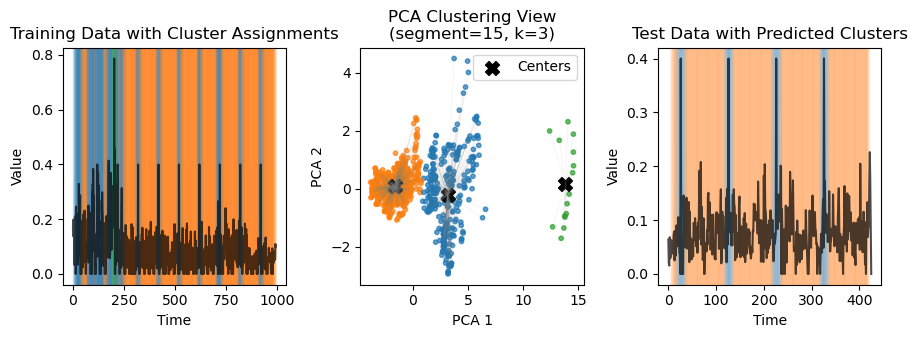

=== FINAL RESULTS ===
len=15, k=3
Training silhouette score: 0.627
Number of test segments: 412
Cluster distribution in test: {0: 60, 1: 352}
Average prediction confidence: 0.493




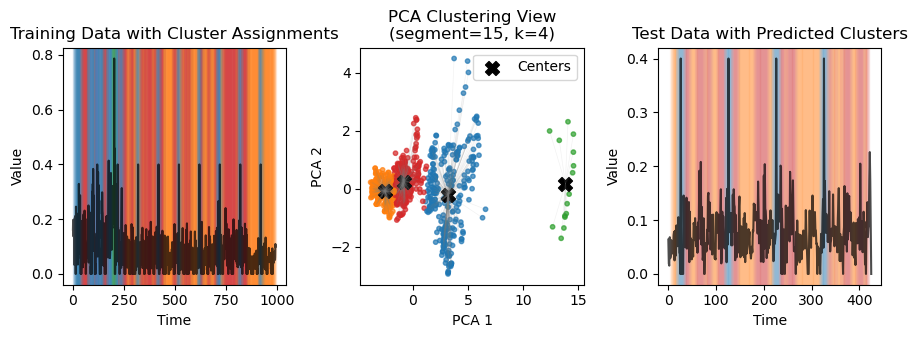

=== FINAL RESULTS ===
len=15, k=4
Training silhouette score: 0.401
Number of test segments: 412
Cluster distribution in test: {0: 60, 1: 174, 3: 178}
Average prediction confidence: 0.526




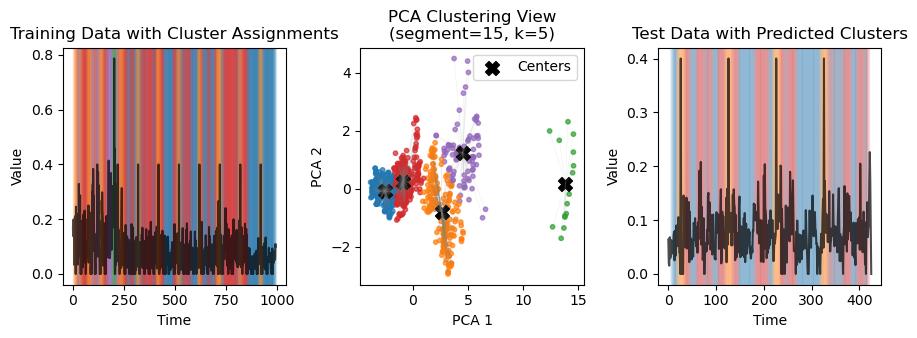

=== FINAL RESULTS ===
len=15, k=5
Training silhouette score: 0.391
Number of test segments: 412
Cluster distribution in test: {0: 173, 1: 60, 3: 179}
Average prediction confidence: 0.530




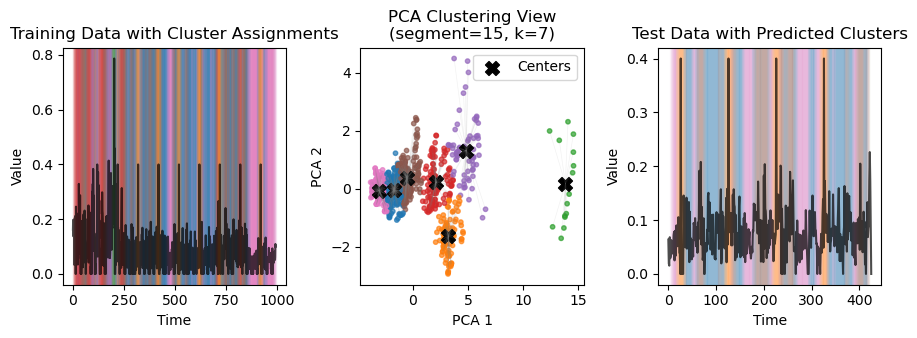

=== FINAL RESULTS ===
len=15, k=7
Training silhouette score: 0.336
Number of test segments: 412
Cluster distribution in test: {0: 150, 1: 57, 3: 3, 5: 107, 6: 95}
Average prediction confidence: 0.559




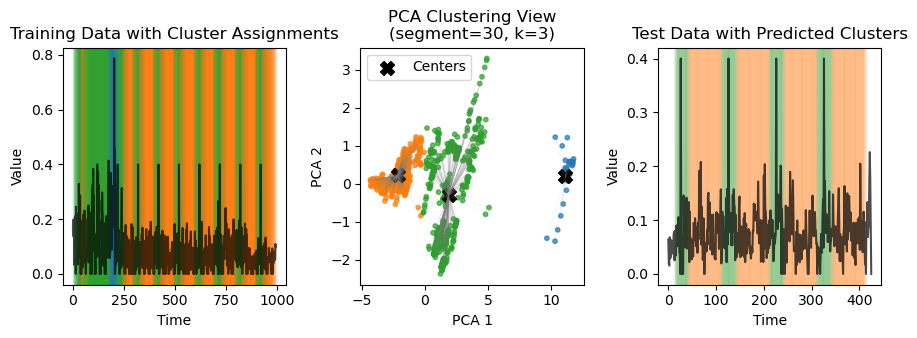

=== FINAL RESULTS ===
len=30, k=3
Training silhouette score: 0.596
Number of test segments: 397
Cluster distribution in test: {1: 280, 2: 117}
Average prediction confidence: 0.507




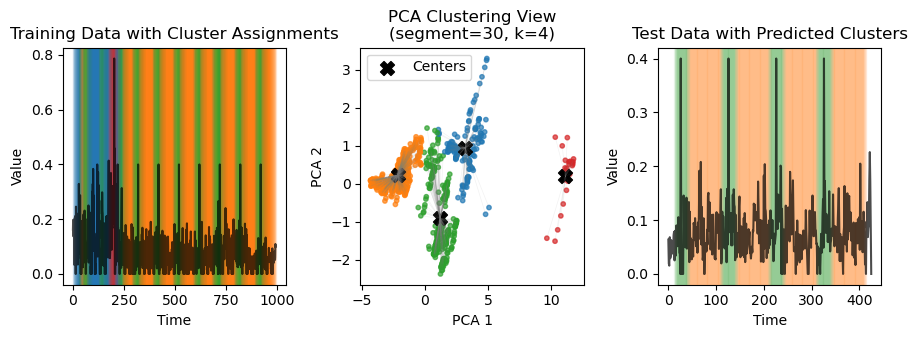

=== FINAL RESULTS ===
len=30, k=4
Training silhouette score: 0.568
Number of test segments: 397
Cluster distribution in test: {1: 280, 2: 117}
Average prediction confidence: 0.534




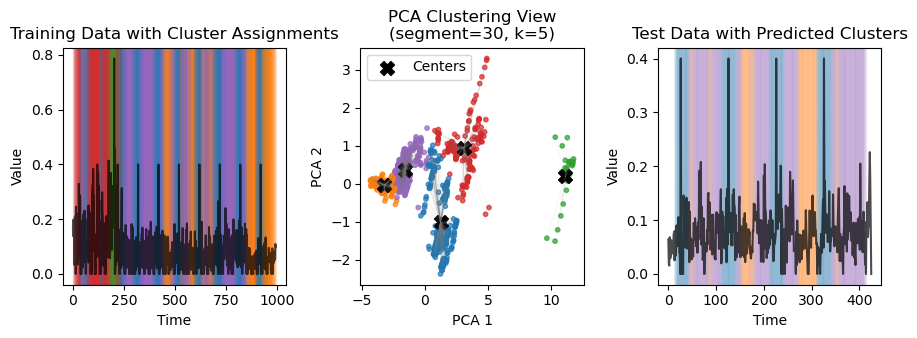

=== FINAL RESULTS ===
len=30, k=5
Training silhouette score: 0.463
Number of test segments: 397
Cluster distribution in test: {0: 117, 1: 77, 4: 203}
Average prediction confidence: 0.559




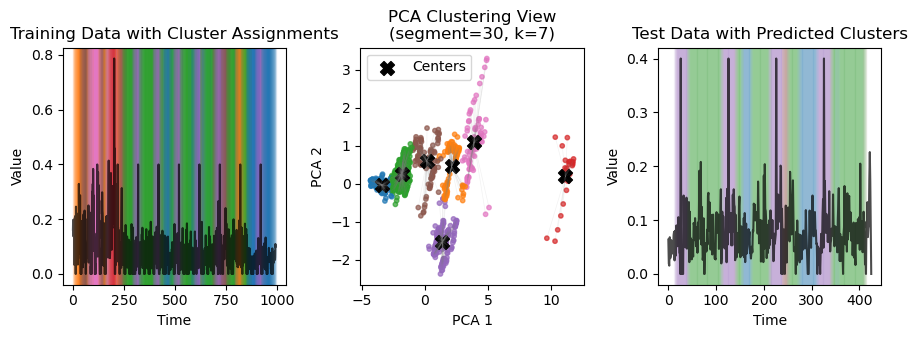

=== FINAL RESULTS ===
len=30, k=7
Training silhouette score: 0.483
Number of test segments: 397
Cluster distribution in test: {0: 59, 1: 1, 2: 211, 4: 114, 5: 12}
Average prediction confidence: 0.543




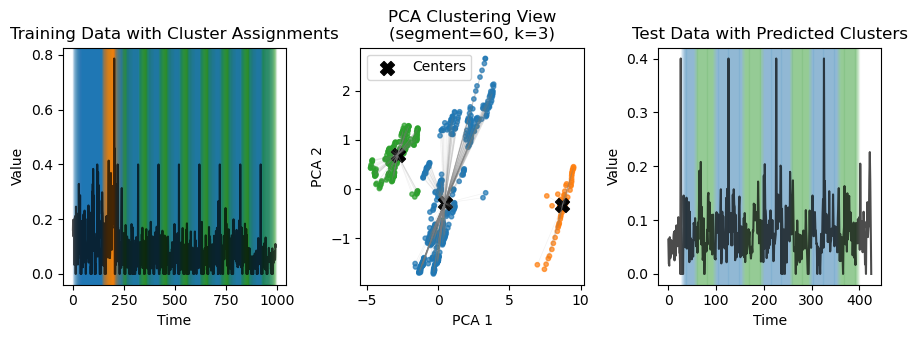

=== FINAL RESULTS ===
len=60, k=3
Training silhouette score: 0.535
Number of test segments: 367
Cluster distribution in test: {0: 207, 2: 160}
Average prediction confidence: 0.507




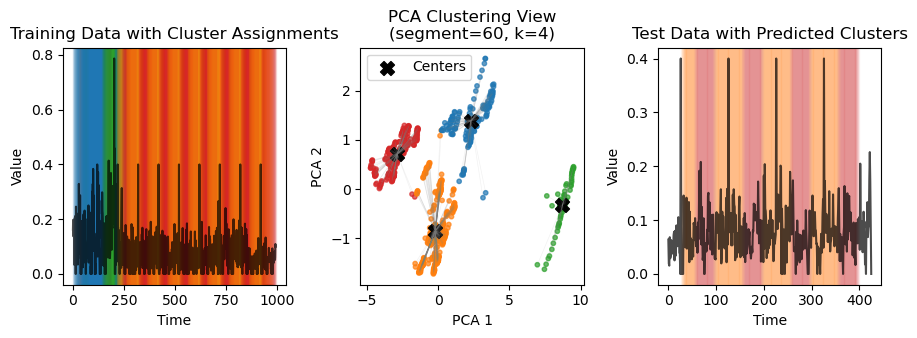

=== FINAL RESULTS ===
len=60, k=4
Training silhouette score: 0.613
Number of test segments: 367
Cluster distribution in test: {1: 207, 3: 160}
Average prediction confidence: 0.544




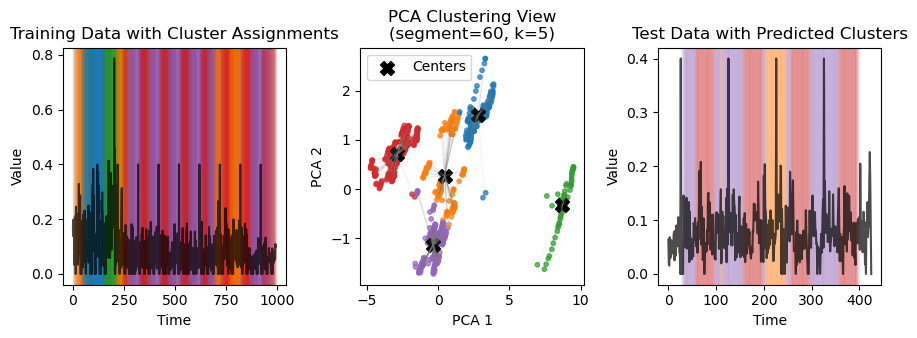

=== FINAL RESULTS ===
len=60, k=5
Training silhouette score: 0.524
Number of test segments: 367
Cluster distribution in test: {1: 49, 3: 160, 4: 158}
Average prediction confidence: 0.535




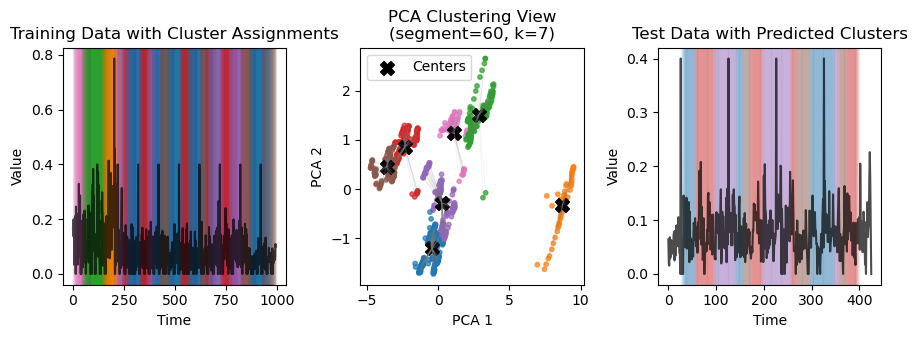

=== FINAL RESULTS ===
len=60, k=7
Training silhouette score: 0.421
Number of test segments: 367
Cluster distribution in test: {0: 94, 3: 102, 4: 113, 5: 58}
Average prediction confidence: 0.557




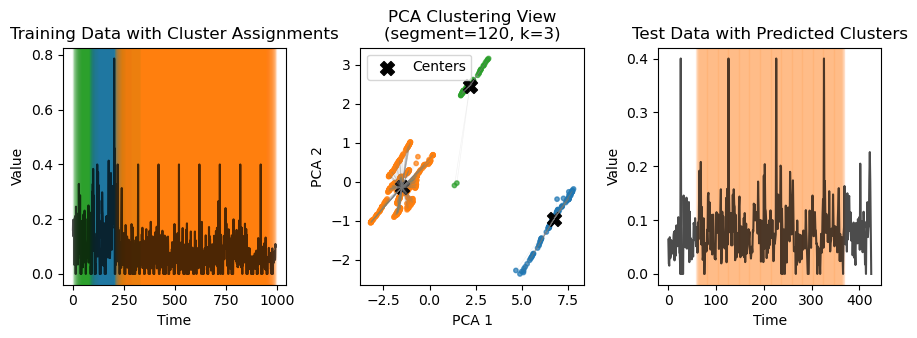

=== FINAL RESULTS ===
len=120, k=3
Training silhouette score: 0.751
Number of test segments: 307
Cluster distribution in test: {1: 307}
Average prediction confidence: 0.507




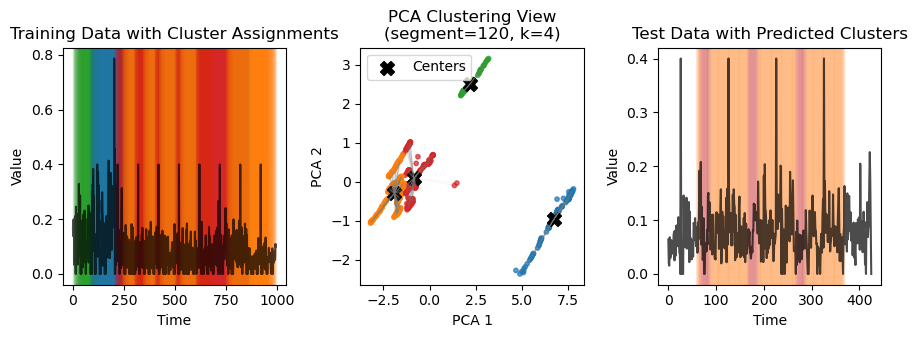

=== FINAL RESULTS ===
len=120, k=4
Training silhouette score: 0.453
Number of test segments: 307
Cluster distribution in test: {1: 248, 3: 59}
Average prediction confidence: 0.525




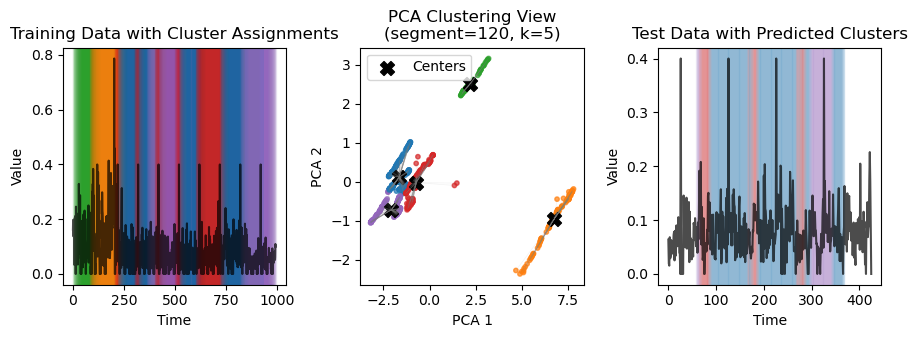

=== FINAL RESULTS ===
len=120, k=5
Training silhouette score: 0.472
Number of test segments: 307
Cluster distribution in test: {0: 207, 3: 46, 4: 54}
Average prediction confidence: 0.534




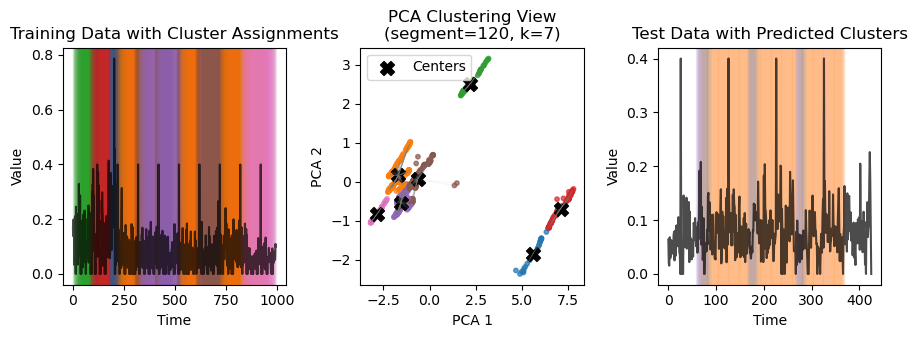

=== FINAL RESULTS ===
len=120, k=7
Training silhouette score: 0.481
Number of test segments: 307
Cluster distribution in test: {1: 242, 4: 12, 5: 51, 6: 2}
Average prediction confidence: 0.521




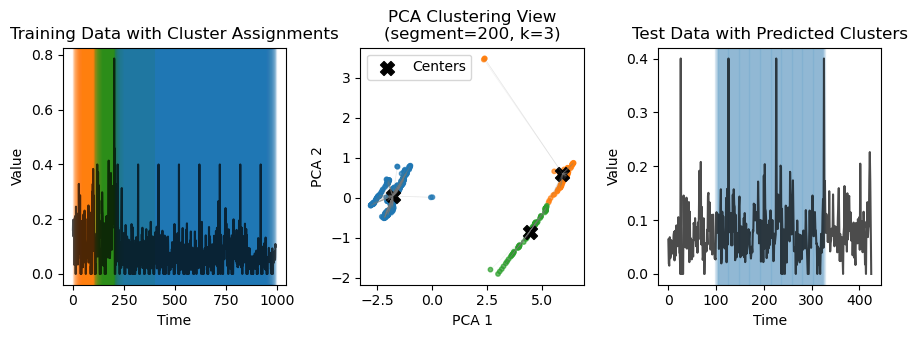

=== FINAL RESULTS ===
len=200, k=3
Training silhouette score: 0.826
Number of test segments: 227
Cluster distribution in test: {0: 227}
Average prediction confidence: 0.491




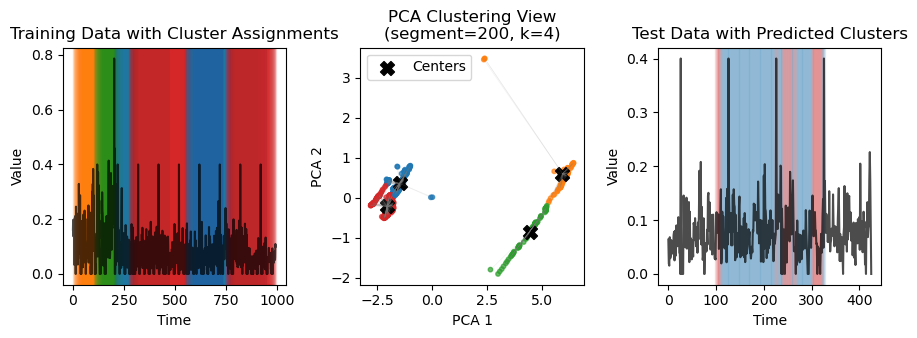

=== FINAL RESULTS ===
len=200, k=4
Training silhouette score: 0.507
Number of test segments: 227
Cluster distribution in test: {0: 173, 3: 54}
Average prediction confidence: 0.486




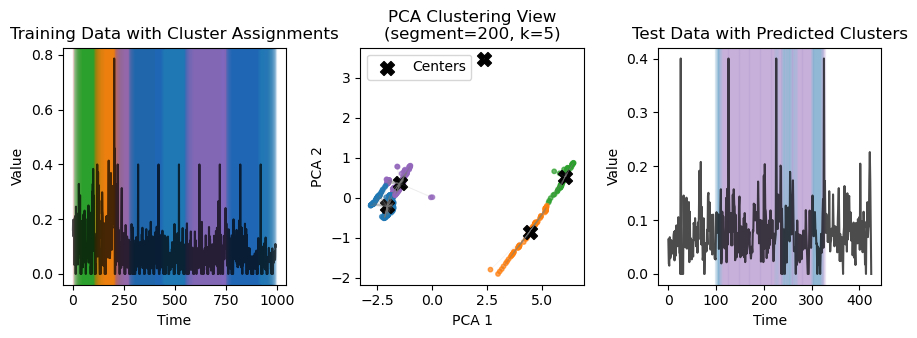

=== FINAL RESULTS ===
len=200, k=5
Training silhouette score: 0.515
Number of test segments: 227
Cluster distribution in test: {0: 54, 4: 173}
Average prediction confidence: 0.486




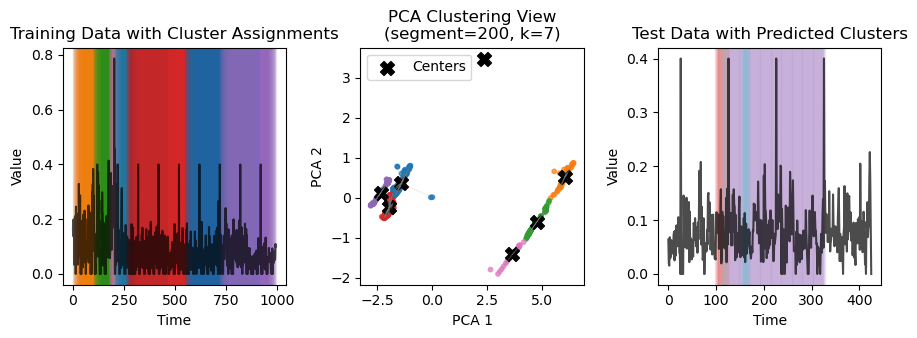

=== FINAL RESULTS ===
len=200, k=7
Training silhouette score: 0.566
Number of test segments: 227
Cluster distribution in test: {0: 18, 3: 21, 4: 188}
Average prediction confidence: 0.521




In [251]:
for segment_length in segment_sizes:
    for n_clusters in cluster_sizes:
        tr, te = prepare_feature(train_data_raw, test_data_raw, segment_length)
        tr, te = scale(tr, te)
        label = cluster(tr, n_clusters)
        plot(tr,label,te,segment_length,n_clusters,train_data_raw,test_data_raw)